# Perfect model $k-\varepsilon$ calibration on Kato-Phillips case
In this notebook, we will demonstrate how get started with _Tunax_ to run a forward model and do a perfect model calibration. Our approach will use the $k-\varepsilon$ closure and will be based on the idealized Kato-Phillips [1] case. This case is characterized by the absence of heat flux and the presence of uniform zonal wind forcing. In a _perfect-model_ framework, the “observations” used for calibration are outputs of a forward model run, generated using a specific set of $k-\varepsilon$ parameters. The goal is for _Tunax_ to successfully retrieve these original parameters through the calibration process.

In [ ]:
import os
import shutil
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes
from typing import List, Tuple, TypeAlias
subplot_1D_type: TypeAlias = Tuple[Figure, List[Axes]]
subplot_2D_type: TypeAlias = Tuple[Figure, List[List[Axes]]]
latex_installed = shutil.which("latex") is not None
plt.rcParams.update({
    'text.usetex': latex_installed,
    'figure.figsize': (8, 5),
    'axes.titlesize': 18,
    'figure.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

## Forward model
In this part we will run the single column model that goes with _Tunax_, with the $k-\varepsilon$ closure with some initial parameters and on the Kato-Phillips case to create our database of "observations". To make a model, _Tunax_ needs a geometry, a initial state, a physical case and some time parameters.

### Geometry
First we have to define the geometry of the water column for our model with the class `Grid`. We use a simple linear geometry with the class method `linear` to create a regular grid with 100 points on a depth of 50 meters. This object contains in part the vector of the depths of the centers of the cells `zr` and the vector of the vector of the interfaces `zw`.

In [2]:
from tunax import Grid
grid = Grid.linear(50, 50)
grid

Grid(nz=50, hbot=f32[], zr=f32[50], zw=f32[51], hz=f32[50])

### Initial state
The initial state for the Kato-Phillips idealized case is defind by zero velocities, a fully stratified temperature and a constant salinity. The class `State` represent these 4 variables state of the water column. To built our initial state we follow these steps
1. we initialize a `State` object defined on our `grid`, every variable is set to 0
2. we reinitialize the temparature and the salinity to our specific case with `init_t` and `init_s` (note that we use the default slope of the stratification for the temperature)
We are obliged to create a new instance of the `State` object everytime that we want to modify an attribute as long as JAX doesn't allow in place modification. It will be the case for all _Tunax_ usage.

In [3]:
from tunax import State
init_state = State.zeros(grid, tracers=['t'])
init_state = init_state.init_t(hmxl=0., t_sfc=16.)
init_state

State(
  grid=Grid(nz=50, hbot=f32[], zr=f32[50], zw=f32[51], hz=f32[50]),
  u=f32[50],
  v=f32[50],
  t=f32[50],
  s=None,
  b=None,
  pt=None
)

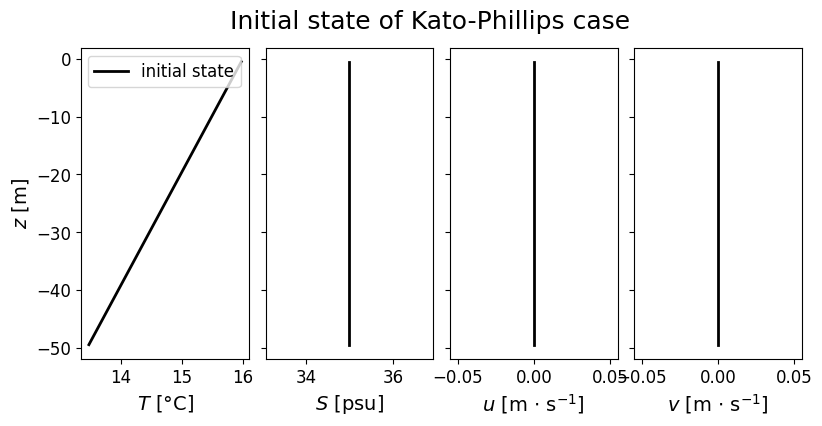

In [4]:
zr = grid.zr

sp: subplot_1D_type = plt.subplots(1, 3, sharey=True, figsize=(7, 4))
fig, [ax_u, ax_v, ax_t] = sp
fig.tight_layout(rect=[0, 0.0, 1, 0.94])
fig.subplots_adjust(wspace=0.1)

ax_u.plot(init_state.u, zr, 'k')
ax_v.plot(init_state.v, zr, 'k', label='initial state')
ax_t.plot(init_state.t, zr, 'k')

if latex_installed:
    ax_t.set_xlabel (r'$T [{}^\circ\mathrm C]$')
    ax_s.set_xlabel(r'$S \ [\mathrm{psu}]$')
    ax_u.set_xlabel(r'$u \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
    ax_v.set_xlabel(r'$v \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
    ax_t.set_ylabel(r'$z [\mathrm m]$')
else:
    ax_t.set_xlabel ('$T$ [°C]')
    ax_s.set_xlabel('$S$ [psu]')
    ax_u.set_xlabel(r'$u$ [m $\cdot$ s${}^{-1}$]')
    ax_v.set_xlabel(r'$v$ [m $\cdot$ s${}^{-1}$]')
    ax_t.set_ylabel(r'$z$ [m]')
ax_t.legend()
fig.suptitle('Initial state of Kato-Phillips case')

plt.show()

### Physical case of Kato-Phillips
Here we will initialize the physical case of our Kato-Phillips experiments, which as we said correspond to no heat flux and a constant zonal wind of $0.01 \text m \cdot \text s ^{-1}$. The class `Case` contains all the physical parameters (forcings and physical constants) for a run of the model. Calling the constructor of this class create an instance with default values in it, they need to be modified to add the forcings.

In [5]:
from tunax import Case
kp_case = Case(t_forcing=(0., 0.))
kp_case = kp_case.set_dynamic_forcing_speed('u', 'sfc', 0.01)
kp_case

Case(
  rho0=1024.0,
  grav=9.81,
  cp=3985.0,
  eos_tracers='t',
  alpha=0.0002,
  beta=0.0008,
  t_rho_ref=0.0,
  s_rho_ref=35.0,
  do_pt=False,
  vkarmn=0.384,
  fcor=0.0,
  ustr_sfc=0.0001,
  ustr_btm=0.0,
  vstr_sfc=0.0,
  vstr_btm=0.0,
  t_forcing=(0.0, 0.0),
  s_forcing=None,
  b_forcing=None,
  pt_forcing=None,
  t_forcing_type='borders',
  s_forcing_type=None,
  b_forcing_type=None,
  pt_forcing_type=None
)

### Initialization of the model
Now that we have a initial condition, a grid and a physical case, we can defined the forward model instance with the class `SingleColumnModel`. For that we need to add the lentght of our model `time_frame`, the duration of one time-step `dt` the time between 2 outputs `out_dt`, and last but not least, the name of the closure that we will use, here it's `'k-epsilon'`. Here we do a simulation of $30 \text h$.

In [6]:
from tunax import SingleColumnModel
time_frame = 30.
dt = 30.
out_dt = 300.
model = SingleColumnModel(time_frame, dt, out_dt, init_state, kp_case, 'k-epsilon')
model

SingleColumnModel(
  nt=3600,
  dt=30.0,
  n_out=10,
  init_state=State(
    grid=Grid(nz=50, hbot=f32[], zr=f32[50], zw=f32[51], hz=f32[50]),
    u=f32[50],
    v=f32[50],
    t=f32[50],
    s=None,
    b=None,
    pt=None
  ),
  case=Case(
    rho0=1024.0,
    grav=9.81,
    cp=3985.0,
    eos_tracers='t',
    alpha=0.0002,
    beta=0.0008,
    t_rho_ref=0.0,
    s_rho_ref=35.0,
    do_pt=False,
    vkarmn=0.384,
    fcor=0.0,
    ustr_sfc=0.0001,
    ustr_btm=0.0,
    vstr_sfc=0.0,
    vstr_btm=0.0,
    t_forcing=(0.0, 0.0),
    s_forcing=None,
    b_forcing=None,
    pt_forcing=None,
    t_forcing_type='borders',
    s_forcing_type=None,
    b_forcing_type=None,
    pt_forcing_type=None
  ),
  closure=Closure(
    name='k-epsilon',
    parameters_class=<class 'tunax.closures.k_epsilon.KepsParameters'>,
    state_class=<class 'tunax.closures.k_epsilon.KepsState'>,
    step_fun=<wrapped function keps_step>
  ),
  output_path=''
)

### Closure parameters
The $k-\varepsilon$ closure is included in the _Tunax_ sources. One can find it in `src/closures/k_epsilon.py`. Here we initialize the parameters of $k-\varepsilon$ with their default values, by calling the constructor of `KepsParameters` class which contains all these parameters.

In [7]:
from tunax.closures import KepsParameters
keps_default_params = KepsParameters()
keps_default_params

KepsParameters(
  c1=5.0,
  c2=0.8,
  c3=1.968,
  c4=1.136,
  c5=0.0,
  c6=0.4,
  cb1=5.95,
  cb2=0.6,
  cb3=1.0,
  cb4=0.0,
  cb5=0.3333,
  cbb=0.72,
  c_mu0=0.5477,
  sig_k=1.0,
  sig_eps=1.3,
  c_eps1=1.44,
  c_eps2=1.92,
  c_eps3m=-0.4,
  c_eps3p=1.0,
  chk_grav=1400.0,
  galp=0.53,
  z0s_min=0.01,
  z0b_min=0.01,
  z0b=1e-14,
  akt_min=1e-05,
  akv_min=0.0001,
  tke_min=1e-06,
  eps_min=1e-12,
  c_mu_min=0.1,
  c_mu_prim_min=0.1,
  dir_sfc=False,
  dir_btm=True,
  gls_p=3,
  gls_m=1.5,
  gls_n=-1,
  sf_d0=19913.90625,
  sf_d1=5087.41065,
  sf_d2=571.8541632000001,
  sf_d3=103.99979766988804,
  sf_d4=172.80647999999997,
  sf_d5=-0.6715392000000003,
  sf_n0=2124.1500000265514,
  sf_n1=345.3003360057121,
  sf_n2=-2.40000000003,
  sf_nb0=2231.25,
  sf_nb1=90.0,
  sf_nb2=17.66630399938841,
  lim_am0=42300123.961466245,
  lim_am1=17682701.851643827,
  lim_am2=2123751.491340626,
  lim_am3=59670.13560796435,
  lim_am4=1214704.020776464,
  lim_am5=418372.60492247937,
  lim_am6=35911.165079

### Run the model
Now we can run our model with these default values of $k-\varepsilon$ parameters. The run don't modify the `model` instance (as long as we use JAX which don't allow in place modification) but returns a object of the class `Trajectory`. This class is simply the set of the timeseries of the velocities and the tracers. It's like a _pandas_ dataframe but defined inside _Tunax_.

In [8]:
traj_obs = model.compute_trajectory_with(keps_default_params)
traj_obs

Trajectory(
  grid=Grid(nz=50, hbot=f32[], zr=f32[50], zw=f32[51], hz=f32[50]),
  time=f32[360],
  u=f32[360,50],
  v=f32[360,50],
  t=f32[360,50],
  s=None,
  b=None,
  pt=None
)

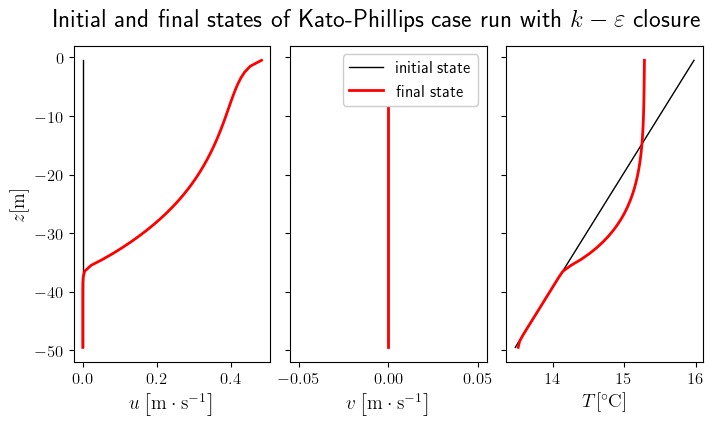

In [19]:
zr = grid.zr

sp: subplot_1D_type = plt.subplots(1, 3, sharey=True, figsize=(7, 4))
fig, [ax_u, ax_v, ax_t] = sp
fig.tight_layout(rect=[0, 0.0, 1, 0.94])
fig.subplots_adjust(wspace=0.1)

ax_u.plot(traj_obs.u[0, :], zr, 'k', linewidth=1)
ax_u.plot(traj_obs.u[-1, :], zr, 'r')
ax_v.plot(traj_obs.v[0, :], zr, 'k', linewidth=1, label='initial state')
ax_v.plot(traj_obs.v[-1, :], zr, 'r', label='final state')
ax_t.plot(traj_obs.t[0, :], zr, 'k', linewidth=1)
ax_t.plot(traj_obs.t[-1, :], zr, 'r')

if latex_installed:
    ax_t.set_xlabel(r'$T [{}^\circ\mathrm C]$')
    ax_s.set_xlabel(r'$S [\mathrm{psu}]$', labelpad=15)
    ax_u.set_xlabel(r'$u \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
    ax_v.set_xlabel(r'$v \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
    ax_t.set_ylabel(r'$z [\mathrm m]$')
    fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')
else:
    ax_t.set_xlabel ('$T$ [°C]')
    ax_s.set_xlabel('$S$ [psu]')
    ax_u.set_xlabel(r'$u$ [m $\cdot$ s${}^{-1}$]')
    ax_v.set_xlabel(r'$v$ [m $\cdot$ s${}^{-1}$]')
    ax_t.set_ylabel(r'$z$ [m]')
    fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')
ax_v.legend(framealpha=1.)

plt.show()

Here we can notice the Stokes drift effect on the zonal velocity $u$ from the wind forcing. We notice that there is no effect on $v$ because we don't consider rotation and Coriolis effect (possible to change it by changing the latitude in `Case`). Then we notice that the Stokes drift has an effect on the temperature a create a mixed layer with almost constant temperature.

## Perfect model calibration
Here we will show how to use the calibration part of _Tunax_ for a problem of a perfect model calibration : we will try to find back the parameters of $k-\varepsilon$ that we just used for the forward model. To configure a experience of calibration, _Tunax_ needs a database, a configuration on the parameters of the closure to calibrate, a loss function and some parameters for the optimizer algorithm.

### Database
In _Tunax_, a `Database` is a list of _obervations_, and an _observation_ (`Obs` class) is the joint of a `Trajetory` object (time-series of the evolution of the state) and a `Case` object that represent a physical situation. These _obervations_ are the basis on what our calibration algorithm is going to make the model and the closure fit on. Typically these observations are extracted from measurments or Large Eddy Simulations (LES), but here, as we are working in a perfect model framework to be more simple, the _observation_ will be created from the output of the model that we just ran.

In [10]:
from tunax import Obs, Database
obs = Obs(traj_obs, kp_case)
database = Database([obs])
database


Database(
  observations=[
    Obs(
      trajectory=Trajectory(
        grid=Grid(nz=50, hbot=f32[], zr=f32[50], zw=f32[51], hz=f32[50]),
        time=f32[360],
        u=f32[360,50],
        v=f32[360,50],
        t=f32[360,50],
        s=None,
        b=None,
        pt=None
      ),
      case=Case(
        rho0=1024.0,
        grav=9.81,
        cp=3985.0,
        eos_tracers='t',
        alpha=0.0002,
        beta=0.0008,
        t_rho_ref=0.0,
        s_rho_ref=35.0,
        do_pt=False,
        vkarmn=0.384,
        fcor=0.0,
        ustr_sfc=0.0001,
        ustr_btm=0.0,
        vstr_sfc=0.0,
        vstr_btm=0.0,
        t_forcing=(0.0, 0.0),
        s_forcing=None,
        b_forcing=None,
        pt_forcing=None,
        t_forcing_type='borders',
        s_forcing_type=None,
        b_forcing_type=None,
        pt_forcing_type=None
      ),
      metadatas={}
    )
  ]
)

### Configurations of parameters to calibrate
To define what parameters of our closure we are going to calibrate, we use the class `FittableParameter` which describes for one parameter if we fit it or not and the initial value in this case. The class `FittableParametersSet` represents the set of all the parameters of the closure that we want to calibrate. Here we calibrate only the parameter $c_1$ of $k-\varepsilon$, the initial value during the calibration is 15. The other parameters are set to the default ones. The default value of $c_1$ used previously in the perfect model is 5, so we expect the value of 15 decrease to 5 during the calibration.

In [11]:
from tunax import FittableParameter, FittableParametersSet
c1_par = FittableParameter(True, 15.)
coef_fit_params = FittableParametersSet({'c1': c1_par}, 'k-epsilon')
coef_fit_params

FittableParametersSet(
  coef_fit_dict={'c1': FittableParameter(do_fit=True, val=15.0)},
  closure=Closure(
    name='k-epsilon',
    parameters_class=<class 'tunax.closures.k_epsilon.KepsParameters'>,
    state_class=<class 'tunax.closures.k_epsilon.KepsState'>,
    step_fun=<wrapped function keps_step>
  )
)

### Loss function
Then we have to define the loss function used in the calibration. This loss function must have the signature `Callable[[List[Trajectory], Database], float]` and the output should be positive. Here we take the squared $L_2$ norm of the difference of the temperature between the obervations and the model at every hour and every depth. This loss function will be wrapped to be a function of the parameters to calibrate. To be more specific, let's note $\theta$ the set of parameters of the closure that we want to calibrate and $U_i$ the vectors of the state at each iteration of the model. Then we can write $\mathcal M_\theta$ the operator of the model that passes from one step to another one
$U_{i+1} = \mathcal M_\theta (U_i)$. The perfect model that we ran previously with the parameters $\theta_p$ can be written
$$U_{\text{obs}} = \mathcal M_{\theta_p}^N (U_0)$$
where $N$ is the number of iterations. Now we can write the loss function that we define of a set of the $k-\varepsilon$ parameters $\theta$
$$\mathcal L(\theta) = \sum_{i \in H} \int_h^0 \left( T\left(U_{\text{obs}}^i\right) - T\left(\mathcal M_\theta^i(U_0)\right) \right) ^2 \, \text d z$$
where $T$ is only the projection that keeps the temperature part of a state $U$, $h=-50$ m is the depth of our column and $H$ is the set of index $i$ so that the time $t_i$ is a multiple of one hour.

In [12]:
from tunax import Trajectory
from typing import List
def loss(trajectories: List[Trajectory], database: Database):
    t_obs = database.observations[0].trajectory.t
    t_scm = trajectories[0].t
    return jnp.sum((t_scm[::10]-t_obs[::10])**2)

Here `trajectories` represent the different run of the model with the configuration of every case in the database (here we just have one). We can visualize there the location of the observations space with the vertical red lines.

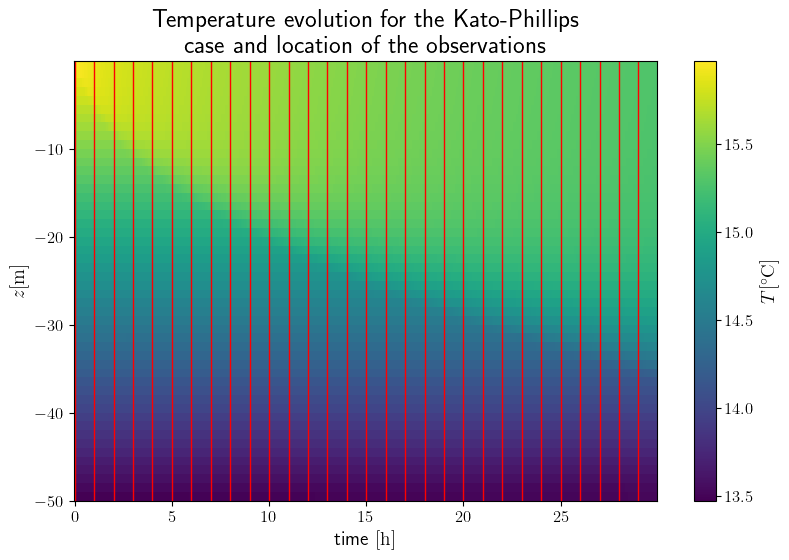

In [ ]:
time = traj_obs.time/3600
x, y = jnp.meshgrid(time, traj_obs.grid.zr)

fig, ax = plt.subplots()
fig.tight_layout()

pcm = ax.pcolormesh(x, y, traj_obs.t.transpose(), shading='nearest')
for t in time[::12]:
    ax.axvline(x=t, color='r', linewidth=1)
cb = fig.colorbar(pcm)

if latex_installed:
    ax.set_xlabel(r'\mathrm{time} $[\mathrm h]$')
    ax.set_ylabel(r'$z [\mathrm m]$')
    cb.set_label(r'$T [{}^\circ\mathrm C]$')
else:
    ax.set_xlabel('time [h]')
    ax.set_ylabel('$z$ [m]')
    cb.set_label('$T$ [°C]')
ax.set_title('Temperature evolution for the Kato-Phillips\n case and location of the observations')

plt.show()

### Definition and call of the fitter
Adding some parametes for the optmizer, we can define the instance of the class `Fitter` that will execute the calibration. An obect of this class contains the informations of how to do the calibration. The call of this object will try to find the best parameters of the closure to minmize the loss functions that we defined just before. First, the fitter compute the gradient function of the loss function, which is doable because JAX is a differentiable langage. Then it does a loop where at each steps it computes the gradient function on a point of the space of the parameters, then an optimization algorithm described by the `Optax` package computes the next point to explore.

In [14]:
from tunax import Fitter
nloop = 50
nit_loss = 1
learning_rate = .5
dt_cal = 300.
if not os.path.exists('k-epsilon_Kato-Phillips'):
    os.mkdir('k-epsilon_Kato-Phillips')
output_path = 'k-epsilon_Kato-Phillips/c1_evolution.npz'
f = Fitter(coef_fit_params, database, dt_cal, loss, nloop, nit_loss=nit_loss, learning_rate=learning_rate, output_path=output_path)
keps_params_calibrated = f()


                    loop 0
                    x [15.]
                    grads [0.32972896]
                

                    loop 1
                    x [14.500003]
                    grads [0.35116145]
                

                    loop 2
                    x [13.999435]
                    grads [0.3605777]
                

                    loop 3
                    x [13.498251]
                    grads [0.40446723]
                

                    loop 4
                    x [12.995434]
                    grads [0.41928393]
                

                    loop 5
                    x [12.490977]
                    grads [0.4454315]
                

                    loop 6
                    x [11.984514]
                    grads [0.4539764]
                

                    loop 7
                    x [11.4762335]
                    grads [0.47406465]
                

                    loop 8
                    x [10.965845]
  

The output of the fitter is the final value of the calibrated parameters of the closure (here only $c_1$ has changed).

In [15]:
keps_params_calibrated.c1

Array(4.2151527, dtype=float32)

The evolution of the calibrated parameters and their gradients have been written and we can visualize them.

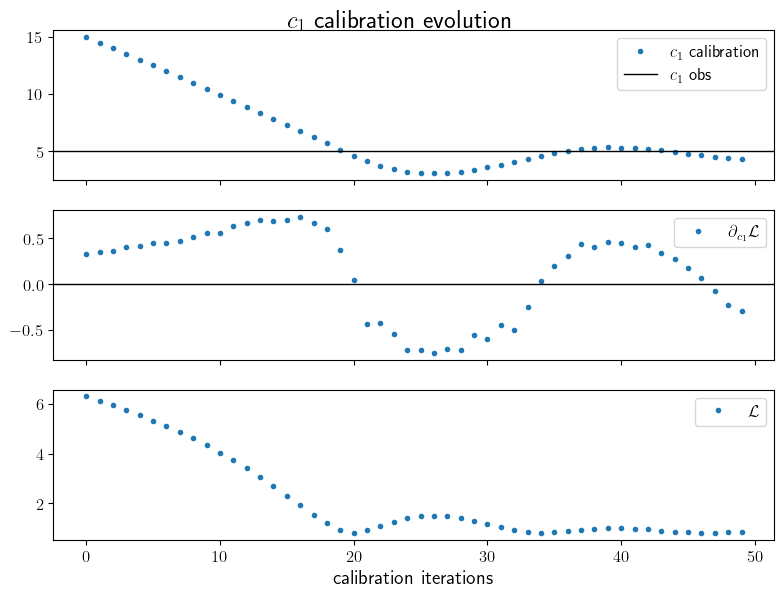

In [16]:
data = np.load(output_path, allow_pickle=True)
c1_ev = data['x'][0, :]
c1_grad_ev = data['grads'][0, :]
loss_it = data['loss_it']
loss_values = data['loss_values']

sp: subplot_1D_type = plt.subplots(3, 1, sharex=True, figsize=(8, 6))
fig, [ax_x, ax_g, ax_l] = sp
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

ax_x.plot(c1_ev, '.', label='$c_1$ calibration')
ax_x.axhline([5.], color='k', linewidth=1, label='$c_1$ obs')
ax_g.plot(c1_grad_ev, '.')
ax_g.axhline(0, color='k', linewidth=1)
ax_l.plot(loss_it, loss_values, '.')

ax_l.set_xlabel('calibration iterations')
ax_x.legend()
if latex_installed:
    ax_g.legend([r'$\partial_{c_1} \mathcal L$'])
    ax_l.legend([r'$\mathcal L$'])
else:
    ax_g.legend([r'$\partial_{c_1} L$'])
    ax_l.legend(['$L$'])
fig.suptitle('$c_1$ calibration evolution')

plt.show()

### Check of the results
One can see that the value of $c_1$ has decreased from 15 to around 5 as expected. We can run the model with these calibrated parameters.

In [17]:
traj_calibrated = model.compute_trajectory_with(keps_params_calibrated)

keps_params_uncalibrated = coef_fit_params.fit_to_closure(coef_fit_params.gen_init_val())
traj_uncalibrated = model.compute_trajectory_with(keps_params_uncalibrated)

Now let's visualize these results on the final state. Remember that here we did the calibration onlt on the temperature, it's a reason why the calibration on the meridional speed $u$ seems to work less.

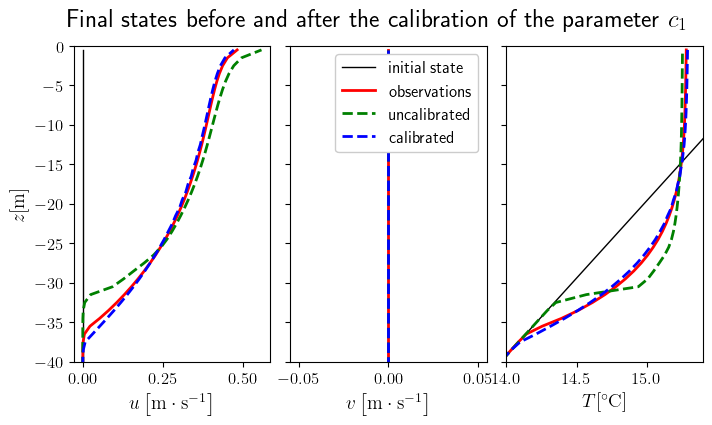

In [18]:
sp: subplot_1D_type = plt.subplots(1, 3, sharey=True, figsize=(7, 4))
fig, [ax_u, ax_v, ax_t] = sp
fig.tight_layout(rect=[0, 0.0, 1, 0.94])
fig.subplots_adjust(wspace=0.1)

ax_u.plot(traj_obs.u[0, :], zr, 'k', linewidth=1)
ax_u.plot(traj_obs.u[-1, :], zr, 'r')
ax_u.plot(traj_uncalibrated.u[-1, :], zr, 'g--')
ax_u.plot(traj_calibrated.u[-1, :], zr, 'b--')
ax_v.plot(traj_obs.v[0, :], zr, 'k', linewidth=1, label='initial state')
ax_v.plot(traj_obs.v[-1, :], zr, 'r', label='observations')
ax_v.plot(traj_uncalibrated.v[-1, :], zr, 'g--', label='uncalibrated')
ax_v.plot(traj_calibrated.v[-1, :], zr, 'b--', label='calibrated')
ax_t.plot(traj_obs.t[0, :], zr, 'k', linewidth=1)
ax_t.plot(traj_obs.t[-1, :], zr, 'r')
ax_t.plot(traj_uncalibrated.t[-1, :], zr, 'g--')
ax_t.plot(traj_calibrated.t[-1, :], zr, 'b--')

ax_t.set_xlim(14, 15.4)
ax_u.set_xlabel(r'$u \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
ax_v.set_xlabel(r'$v \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
ax_t.set_xlabel(r'$T [{}^\circ\mathrm C]$')
ax_u.set_ylim(-40, 0)
ax_u.set_ylabel(r'$z [\mathrm m]$')
ax_v.legend(framealpha=1.)
if latex_installed:
    ax_t.set_xlabel(r'$T [{}^\circ\mathrm C]$')
    ax_s.set_xlabel(r'$S [\mathrm{psu}]$', labelpad=15)
    ax_u.set_xlabel(r'$u \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
    ax_v.set_xlabel(r'$v \left[\mathrm m \cdot \mathrm s^{-1}\right]$')
    ax_t.set_ylabel(r'$z [\mathrm m]$')
    fig.suptitle(r'Initial and final states of Kato-Phillips case run with $k-\varepsilon$ closure')
else:
    ax_t.set_xlabel ('$T$ [°C]')
    ax_s.set_xlabel('$S$ [psu]')
    ax_u.set_xlabel(r'$u$ [m $\cdot$ s${}^{-1}$]')
    ax_v.set_xlabel(r'$v$ [m $\cdot$ s${}^{-1}$]')
    ax_t.set_ylabel(r'$z$ [m]')
plt.suptitle('Final states before and after the calibration of the parameter $c_1$')

plt.show()

## References
1. Kato H, Phillips OM. On the penetration of a turbulent layer into stratified fluid. Journal of Fluid Mechanics. 1969;37(4):643-655. doi : [10.1017/S0022112069000784](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/on-the-penetration-of-a-turbulent-layer-into-stratified-fluid/1D763D80170943E6FFA0573DFE20F091)